In [ ]:
# !pip install numpy pandas scipy 

In [1]:
import numpy as np
from scipy.linalg import lstsq
import random
import pandas as pd
import os
type_converter = {i: lambda x: int(x, 16) for i in range(16)}
LAB_PATH = "/scratch/net4/HOS/Traces"
# LAB_PATH = '/scratch/net4/HOS/traces'
MAX_ROWS = 10000 #Total Number of rows to be selected
ROUND1_START = 20000
ROUND1_END = 25000

AES_SBOX = [0x6, 0xB, 0x5, 0x4, 0x2, 0xE, 0x7, 0xA,0x9, 0xD, 0xF, 0xC, 0x3, 0x1, 0x0, 0x8]
random_plaintexts = np.loadtxt(os.path.join(LAB_PATH,"plaintexts.txt"), dtype=np.uint8, max_rows=MAX_ROWS, converters=type_converter)
random_traces = np.loadtxt(os.path.join(LAB_PATH,"traces.txt"), max_rows=MAX_ROWS)
unscaled_traces = random_traces[:,ROUND1_START:ROUND1_END]
SCALE = 3
m_off = 0
scaled_traces = ((unscaled_traces / 127) * 4) * SCALE + m_off

print("unscaled traces shape: ", unscaled_traces.shape)
print("scaled traces shape: ", scaled_traces.shape)

unscaled traces shape:  (10000, 5000)
scaled traces shape:  (10000, 5000)


In [ ]:
def standardize_traces(traces):
    # traces: (n_traces, n_samples)
    m = traces.mean(axis=1, keepdims=True)
    s = traces.std(axis=1, keepdims=True) + 1e-12
    return (traces - m) / s

std_scaled = standardize_traces(scaled_traces)

In [14]:
def moving_average(traces, win=5):
    if win <= 1: return traces
    kernel = np.ones(win) / win
    pad = win // 2
    padded = np.pad(traces, ((0,0),(pad,pad)), mode='edge')
    smoothed = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='valid'), 1, padded)
    return smoothed

avg_unscaled = moving_average(unscaled_traces)

In [3]:
PROFILING = 9000 #Number of traces for profiling 
ATTACK = 1000 #Number of traces for Attack
TYPE = "bits" # Type for basis function "bits" or "hw_bits"
MODE = "S2" #mode usually S2 (selects top 10 from Norm of Beta)
ATTACK_START = 9000 #start of attack traces
ATTACK_END = 10000 #end of attack traces

In [4]:

class BasisFunctions:
    """Handles the precomputation of the basis matrix G for a 4-bit S-Box."""
    def __init__(self, sbox, basis_type='bits'):
        self.sbox = sbox
        self.num_basis = 5
        self.basis_type = basis_type
        self.G = self._build_basis_matrix()

    def _build_basis_matrix(self):
        """Precomputes the basis matrix G for all phi values (0-15) based on actual bit value and HW"""
        G = np.zeros((16, self.num_basis), dtype=float)
        for phi in range(16):
            sbox_output = self.sbox[phi]
            if(self.basis_type == 'bits'):
                G[phi] = [1.0]+[float(i) for i in format(sbox_output, '04b')]
            elif(self.basis_type == 'hw_bits'):
                G[phi] = [1.0] + [float(i) for i in format(bin(sbox_output).count('1'),'04b')]
        return G

class Profiling:
    """Manages the profiling phase: beta estimation, time point selection, and covariance estimation."""
    def __init__(self, basis_functions):
        self.basis_functions = basis_functions
        self.betas = None
        self.ts = None
        self.cov = None

    def estimate_betas(self, traces_prof, x_prof, k_b, start_time, end_time):
        """Estimates beta coefficients for time points in [start_time:end_time]."""
        N1 = len(x_prof)
        phi_prof = np.bitwise_xor(x_prof, k_b) & 0x0F
        G_prof = self.basis_functions.G[phi_prof]
        segment_length = end_time - start_time
        self.betas = np.zeros((segment_length, 5), dtype=float)
        self.start_time = start_time
        for t_rel, t_abs in enumerate(range(start_time, end_time)):
            i_t = traces_prof[:, t_abs]
            beta_t, _, _, _ = lstsq(G_prof, i_t, lapack_driver='gelsy')
            self.betas[t_rel] = beta_t
        return self.betas

    def select_time_points(self,betas, tau, selection_mode='S2', traces_prof=None):
        """Selects relevant time points ts based on the norm of data-dependent betas."""
        norm_b = np.linalg.norm(betas[:, 1:], axis=1)  # Exclude constant term
        # print(f"Norm of betas: {norm_b}")
        if selection_mode == 'S3':
            self.ts = [np.argmax(norm_b)]  # Single max peak
        elif selection_mode == 'S2':
            self.ts = [int(x) for x in np.argsort(norm_b)[-10:]]  # Top 10 peaks
        elif selection_mode == 'S6':
            self.ts = np.argsort(norm_b)[-21:]  # Top 21 peaks
        elif selection_mode == 'S1':
            self.ts = np.where(norm_b >= tau)[0]  # Threshold-based
        elif selection_mode in ['S4', 'S5']:
            if traces_prof is None:
                raise ValueError("traces_prof required for S4/S5 selection modes")
            var_t = np.var(traces_prof, axis=0)
            mask = (norm_b >= tau) & (norm_b > var_t)
            self.ts = np.where(mask)[0]
            if selection_mode == 'S5':
                extra_mask = (norm_b >= tau / 2) & ~mask
                self.ts = np.concatenate((self.ts, np.where(extra_mask)[0]))
        else:
            raise ValueError(f"Unknown selection_mode: {selection_mode}")
        # self.ts = sorted(self.ts)
        return self.ts
    
    def detect_noise(self, traces_prof, x_prof, k_b):
        """Detect noise levels using residuals after beta fitting."""
        if self.betas is None:
            raise ValueError("Run estimate_betas first")
        
        # Compute predicted h_t for all t in segment
        phi_prof = np.bitwise_xor(x_prof, k_b) & 0x0F
        G_prof = self.basis_functions.G[phi_prof]  # N1 x 5
        h_pred = np.dot(G_prof, self.betas.T)  # N1 x segment_length
        
        # Residuals = observed - predicted
        segment_traces = traces_prof[:, self.start_time:self.start_time + len(self.betas)]
        residuals = segment_traces - h_pred
        
        # Noise metrics
        noise_var = np.var(residuals)  # Overall var(R_t)
        signal_var = np.var(h_pred)    # var(h_t)
        snr = signal_var / noise_var if noise_var > 0 else float('inf')
        
        # Per-time variance
        noise_var_per_t = np.var(residuals, axis=0)  # segment_length x 1
        
        return snr, noise_var, noise_var_per_t

    def estimate_covariance(self, traces_noise, x_noise, k_b):
        """Estimates the covariance matrix of residuals for ML key extraction."""
        N2 = len(x_noise)
        m = len(self.ts)
        phi_noise = np.bitwise_xor(x_noise, k_b) & 0x0F
        G_phi = self.basis_functions.G[phi_noise]  # [N2, 5]
        betas_ts = self.betas[self.ts]  # [m, 5]
        h_star_all = np.einsum('ij,kj->ik', G_phi, betas_ts)  # [N2, m]
        residuals = traces_noise[:, self.ts] - h_star_all
        self.cov = np.cov(residuals.T)

class KeyExtraction:
    """Handles key extraction using minimum or maximum likelihood principles."""
    def __init__(self, profiling):
        self.profiling = profiling
        self.basis_functions = profiling.basis_functions
        self.betas = profiling.betas
        self.ts = profiling.ts
        self.cov = profiling.cov

    def extract_key(self, traces_attack, x_attack,betas, ts,  N3, method='minimum'):
        """Extracts the subkey using the specified method."""
        G = self.basis_functions.G
        if method == 'minimum':
            min_diff = float('inf')
            best_k = None
            for k_prime in range(16):
                diff = 0.0
                for j in range(N3):
                    phi_j = np.bitwise_xor(x_attack[j], k_prime) & 0x0F
                    h_j = np.array([G[phi_j] @ betas[t] for t in ts])
                    i_j = traces_attack[j,ts]
                    diff += np.sum((i_j - h_j) ** 2)
                avg_diff = diff / N3
                if avg_diff < min_diff:
                    min_diff = avg_diff
                    best_k = k_prime
            return best_k
        elif method == 'ml':
            if self.cov is None:
                raise ValueError("Covariance matrix required for ML method")
            try:
                cov_inv = np.linalg.inv(self.cov)
            except np.linalg.LinAlgError:
                cov_inv = np.linalg.pinv(self.cov)
            min_val = float('inf')
            best_k = None
            for k_prime in range(16):
                val = 0.0
                for j in range(N3):
                    phi_j = np.bitwise_xor(x_attack[j], k_prime) & 0x0F
                    h_j = np.array([G[phi_j] @ self.betas[t] for t in self.ts])
                    i_j = traces_attack[j, self.ts]
                    delta = i_j - h_j
                    val += delta.T @ cov_inv @ delta
                if val < min_val:
                    min_val = val
                    best_k = k_prime
            return best_k
        else:
            raise ValueError(f"Unknown method: {method}")

    def compute_success_rate(self, traces_attack, x_attack,betas,timepoints, correct_k, sampled=50, num_trials=10, method='minimum'):
        """Computes the success rate over multiple trials with random subsets."""
        num_attack = len(x_attack)
        success = 0
        # print(f"From the total samples of {num_attack}, {sampled} samples taken at a time and {num_trials} were run to find success rate.")
        for _ in range(num_trials):
            indices = random.sample(range(num_attack), sampled)
            traces_sub = traces_attack[indices]
            x_sub = x_attack[indices]
            extracted_k = self.extract_key(traces_sub, x_sub,betas, timepoints, sampled, method)
            if extracted_k == correct_k:
                success += 1
        return (success / num_trials) * 100

In [20]:
SNR , NOISE_VAR, NOISE_PER_T = [],[],[]
def run_stochastic_dpa(byte_idx, plaintexts, traces_all, key, start_time, end_time, N1=1000, N2=1000,N3 = 10, tau=0.1, basis_type = 'bits',selection_mode='S2', method='minimum'):
    """
    Run profiling and extraction for one byte within time segment [start_time:end_time].
    Assume traces_all [total_samples, length], plaintexts [total_samples, 16]
    key: full key nibbles (each 0-15)
    Split: 0:N1+N2 for prof, rest for attack
    tau: threshold for norm_b
    method: 'minimum' or 'ml'
    """
    if not (0 <= start_time < end_time <= traces_all.shape[1]):
        raise ValueError(f"Invalid time segment: [{start_time}:{end_time}]")
    
    total_prof = N1 + N2 if method == 'ml' else N1
    # if total_prof + N3 > traces_all.shape[0]:
    #     raise ValueError("Not enough traces for profiling and attack")
    
    # byte_idx of all the plain text is taken as column vector
    plaintexts_all = plaintexts[:, byte_idx] & 0x0F  # Lower 4 bits
    k_b = key[byte_idx] & 0x0F
    
    traces_prof = traces_all[:total_prof] #shape (total_prof, 5000)
    plaintexts_prof = plaintexts_all[:total_prof] #shape(total_prof,)
    AES_SBOX = [0x6, 0xB, 0x5, 0x4, 0x2, 0xE, 0x7, 0xA,0x9, 0xD, 0xF, 0xC, 0x3, 0x1, 0x0, 0x8]

    bf = BasisFunctions(AES_SBOX, basis_type=basis_type)
    prof = Profiling(bf)
    
    betas = prof.estimate_betas(traces_prof[:N1], plaintexts_prof[:N1], k_b, start_time, end_time)

    if selection_mode in ['S4', 'S5']:
        timepoints = prof.select_time_points(betas, tau, selection_mode=selection_mode, traces_prof=traces_prof[:N1])
    else:
        timepoints = prof.select_time_points(betas, tau, selection_mode=selection_mode)
    
    snr, noise_var, noise_var_per_t = prof.detect_noise(traces_prof[:N1], plaintexts_prof[:N1], k_b)
    SNR.append(snr)
    NOISE_VAR.append(noise_var)
    NOISE_PER_T.append(noise_var_per_t)
    # # Estimate covariance for ML
    if method == 'ml':
        traces_noise = traces_prof[N1:N1 + N2]
        x_noise = plaintexts_prof[N1:N1 + N2]
        prof.estimate_covariance(traces_noise, x_noise, k_b)
    
    # After profiling next N3 traces are taken for attack
    traces_attack = traces_all[total_prof:total_prof + N3]
    plaintext_attack = plaintexts_all[total_prof:total_prof + N3]
    
    ke = KeyExtraction(prof)
    extracted_k = ke.extract_key(traces_attack, plaintext_attack, betas, timepoints, N3, method=method)
    if(extracted_k==k_b):
        sr = ke.compute_success_rate(traces_all[total_prof:], plaintexts_all[total_prof:],betas,timepoints, k_b, sampled=50, num_trials=10, method=method)
        # [ke.betas[i].tolist() for i in ke.ts]
        return extracted_k, ke.ts, ke.betas,sr
    else:
        return extracted_k,ke.ts, ke.betas,0

In [13]:
def create_range(start_time=0, end_time=5000, increments=(5, 10), widths=(10, 20)):
    ranges = set()
    widths = tuple(sorted(widths))
    min_w = widths[0]

    for inc in increments:
        s = start_time
        while s + min_w <= end_time:
            for w in widths:
                end = s + w
                if end > end_time:
                    break
                ranges.add((s, end))
            s += inc
    return sorted(ranges)

In [21]:

key = np.array([15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0], dtype=np.uint8)
df_data = []
for k in range(1): # change here to run for all 16 bytes
    print(f"Running for byte index {k}")
    ranges = create_range(start_time=100, end_time=5000, increments=[10], widths=[10])
    for r in (ranges):
        results = []
        extracted_k, ts, betas, sr = run_stochastic_dpa(
            byte_idx=k,
            plaintexts=random_plaintexts,
            traces_all=avg_unscaled,
            key=key,
            start_time=r[0],
            end_time=r[1],
            N1=PROFILING,
            N2=200,
            N3= ATTACK,
            tau=0.1,
            basis_type= TYPE,
            selection_mode=MODE,
            method='minimum'
        )
        if(extracted_k ==key[k] and sr>0):
            df_data.append({
                'byte_idx': k,
                'range':r,
                'extracted_key': extracted_k,
                'time_points': ts,
                'betas': betas,
                'sr':float(sr)
            })

# df = pd.DataFrame(df_data)
# df.to_csv(f'RESULTS_{PROFILING}_{TYPE}_{MODE}.csv', index=False)

Running for byte index 0


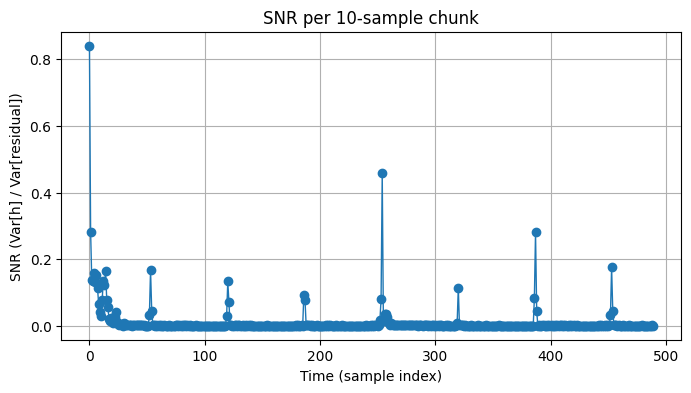

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(SNR, marker='o', linewidth=1)
# plt.plot(x, snrs_smooth, linestyle='--')
plt.xlabel("Time (sample index)")
plt.ylabel("SNR (Var[h] / Var[residual])")
plt.title("SNR per 10-sample chunk")
plt.grid(True)
plt.show()

# If snr >> 1, it means your predictions are strong compared to noise.
# If snr ~ 1, noise is as large as the signal variation.
# If snr << 1, noise dominates.

In [23]:
class Attack:
    """Handles key extraction using minimum or maximum likelihood principles."""
    def __init__(self, basis_functions, betas, ts, cov=None):
        self.basis_functions = basis_functions
        self.betas = betas
        self.ts = ts
        self.cov = cov

    def extract_key(self, traces_attack, plaintexts_attack, byte_idx,N3, method='minimum'):
        """Extracts the subkey using the specified method."""
        m = len(self.ts)
        G = self.basis_functions.G
        plaintexts_attack = plaintexts_attack[:, byte_idx] & 0x0F
        if method == 'minimum':
            min_diff = float('inf')
            best_k = None
            for k_prime in range(16):
                diff = 0.0
                for j in range(N3):
                    phi_j = np.bitwise_xor(plaintexts_attack[j], k_prime) & 0x0F
                    h_j = np.array([G[phi_j] @self.betas[t] for t in self.ts])
                    i_j = traces_attack[j, self.ts]
                    diff += np.sum((i_j - h_j) ** 2)
                avg_diff = diff / N3
                if avg_diff < min_diff:
                    min_diff = avg_diff
                    best_k = k_prime
            return best_k
        elif method == 'ml':
            if self.cov is None:
                raise ValueError("Covariance matrix required for ML method")
            try:
                cov_inv = np.linalg.inv(self.cov)
            except np.linalg.LinAlgError:
                cov_inv = np.linalg.pinv(self.cov)
            min_val = float('inf')
            best_k = None
            for k_prime in range(16):
                val = 0.0
                for j in range(N3):
                    phi_j = np.bitwise_xor(plaintexts_attack[j], k_prime) & 0x0F
                    h_j = np.array([G[phi_j] @ self.betas[t] for t in self.ts])
                    i_j = traces_attack[j, self.ts]
                    delta = i_j - h_j
                    val += delta.T @ cov_inv @ delta
                if val < min_val:
                    min_val = val
                    best_k = k_prime
            return best_k
        else:
            raise ValueError(f"Unknown method: {method}")

    def compute_success_rate(self, traces_attack, 
                             plaintexts_attack, 
                             correct_k, 
                             sampled=50, 
                             num_trials=10, method='minimum'):
        """Computes the success rate over multiple trials with random subsets."""
        num_attack = len(plaintexts_attack)
        success = 0
        print(f"From the total samples of {num_attack}, {sampled} samples taken at a time and {num_trials} were run to find success rate.")
        for _ in range(num_trials):
            indices = random.sample(range(num_attack), sampled)
            traces_sub = traces_attack[indices]
            x_sub = plaintexts_attack[indices]
            extracted_k = self.extract_key(traces_sub, x_sub, sampled, method)
            if extracted_k == correct_k:
                success += 1
        return (success / num_trials) * 100

In [24]:
attack_plaintexts = random_plaintexts[ATTACK_START:ATTACK_END] 
attack_traces = avg_unscaled[ATTACK_START:ATTACK_END]
final_expected = {}
for byte_idx in range(1): # change here to run for all 16 bytes
    byte = [d for d in df_data if d['byte_idx'] == byte_idx]
    count = {i: 0 for i in range(16)}
    for idx in byte:
        betas, ts = idx['betas'], idx['time_points']
        bf_attack = BasisFunctions(AES_SBOX, basis_type=TYPE)
        attack = Attack(bf_attack,betas, ts)
        e_k = attack.extract_key(attack_traces, attack_plaintexts,byte_idx, 10,method='minimum')
        count[e_k] = count[e_k]+1
    filtered = {k: v for k, v in count.items() if v}
    final_expected[byte_idx] = filtered

In [25]:
N = 3
topN = {k: [x for x, _ in sorted(v.items(), key=lambda item: item[1], reverse=True)[:N]]
        for k, v in final_expected.items()}
print(topN)

{0: [9, 14, 3]}
